In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import numpy as np
from skimage import feature, exposure
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import json
import matplotlib.pyplot as plt

# 데이터 준비


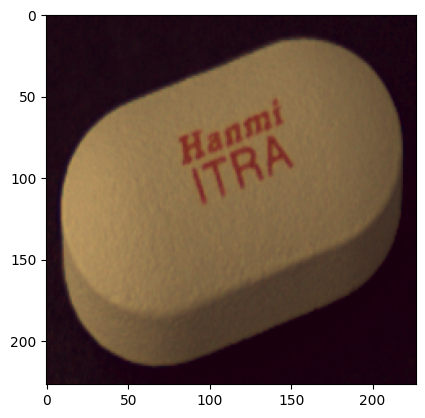

In [2]:
# 이미지를 로드합니다.
image_file_name = "K-009460_0_0_0_0_60_000_200"
pill_image = cv2.imread('C:\\Users\\ewqds\\Documents\\Pill_Data\\1.Training\\image\\K-009460\\'+ image_file_name + '.png', cv2.IMREAD_COLOR)
# 이미지가 성공적으로 불러와졌는지 확인
if pill_image is None:
    raise ValueError(f"이미지를 불러오는 데 실패했습니다.")

# Replace with the path to yresized_imageour JSON file
json_file_path = "C:\\Users\\ewqds\\Documents\\Pill_Data\\1.Training\\Label\\K-009460\\" + image_file_name + ".json"

# image = cv2.imread(pill_image)


# if image is None:
#     print("못불러옴")  # 이미지를 로드하지 못한 경우 건너뜁니다.

# 라벨 데이터를 로드합니다.
with open(json_file_path, 'r') as label_file:
    label_data = json.load(label_file)

# 라벨 데이터에서 분류 라벨을 추출합니다. (예: 'Normal' 또는 'Abnormal')
label = label_data['images'][0]['drug_N']


#===================경게 상자 좌표 추출 작업===================#
# 라벨링 데이터에서 경계 상자 좌표 추출
bbox = label_data['annotations'][0]['bbox']
width, length, w, h = bbox

# 이미지에서 알약 부분 잘라내기
pill_cropped = pill_image[length:length+h, width:width+w]

# 잘라낸 이미지의 크기를 확인하고, 필요한 경우 크기를 조정합니다.
pill_resized = cv2.resize(pill_cropped, (227, 227))

# 잘라낸 알약 이미지를 시각화합니다.
plt.imshow(cv2.cvtColor(pill_resized, cv2.COLOR_BGR2RGB))
plt.show()

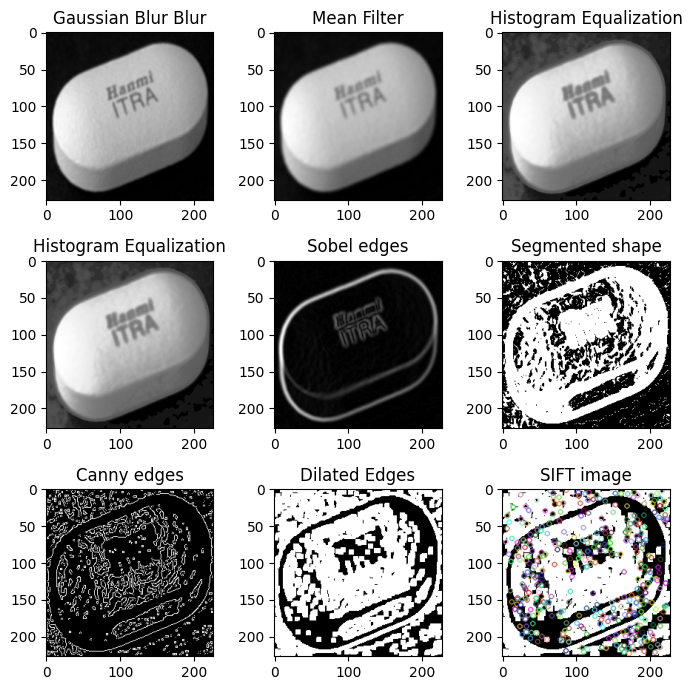

In [3]:
import os
import cv2
import json
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from matplotlib import pyplot as plt

import cv2
import numpy as np
import tensorflow as tf


# 이미지를 그레이스케일로 변환
gray = cv2.cvtColor(pill_resized, cv2.COLOR_BGR2GRAY)

# 가우시안 필터를 적용하여 블러 처리
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# 평균 필터 적용
mean_filtered = cv2.blur(blurred, (5, 5))

# 히스토그램 평활화
equalized = cv2.equalizeHist(mean_filtered)

# Sobel 필터를 사용한 형태 감지
sobelx = cv2.Sobel(mean_filtered, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(mean_filtered, cv2.CV_64F, 0, 1, ksize=5)
sobel = cv2.magnitude(sobelx, sobely)
# 임계값 적용하여 이진 이미지 생성
_, thresholded = cv2.threshold(sobel, 50, 255, cv2.THRESH_BINARY)

# Canny 에지 검출기 사용
canny_edges = cv2.Canny(np.uint8(thresholded), 100, 200)
# Dilution 작업
dilated = cv2.dilate(canny_edges, np.ones((5,5), np.uint8), iterations=1)

# SIFT 및 MLBP (예시로 SIFT만 구현, MLBP는 OpenCV에서 직접적으로 지원하지 않음)
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(dilated, None)
# 결과 이미지 반환 (SIFT 키포인트로 표시된 이미지를 반환합니다)
result_image = cv2.drawKeypoints(dilated, keypoints, None)

# cv2.imshow('Processed Image', processed_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# OpenCV로 이미지를 BGR에서 RGB로 변환
processed_test_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
# # 이미지 표시
# plt.imshow(processed_image_rgb)
# plt.title('Processed Image')
# plt.show()

# 결과 시각화
plt.figure(figsize=(7, 7))
plt.subplot(331), plt.imshow(blurred, cmap='gray'), plt.title('Gaussian Blur Blur')
plt.subplot(332), plt.imshow(mean_filtered, cmap='gray'), plt.title('Mean Filter')
plt.subplot(333), plt.imshow(equalized, cmap='gray'), plt.title('Histogram Equalization')
plt.subplot(334), plt.imshow(equalized, cmap='gray'), plt.title('Histogram Equalization')
plt.subplot(335), plt.imshow(sobel, cmap='gray'), plt.title('Sobel edges')
plt.subplot(336), plt.imshow(thresholded, cmap='gray'), plt.title('Segmented shape')
plt.subplot(337), plt.imshow(canny_edges, cmap='gray'), plt.title('Canny edges')
plt.subplot(338), plt.imshow(dilated, cmap='gray'), plt.title('Dilated Edges')
plt.subplot(339), plt.imshow(result_image, cmap='gray'), plt.title('SIFT image')

plt.tight_layout()
plt.show()  

In [4]:
import os
import cv2
import json
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical

# 이미지와 라벨링 데이터의 경로를 지정합니다.
image_data_folder = 'C:\\Users\\ewqds\\Documents\\Pill_Data\\1.Training\\image\\'
label_data_folder = 'C:\\Users\\ewqds\\Documents\\Pill_Data\\1.Training\\Label\\'

# 학습 및 테스트 데이터를 저장할 리스트를 생성합니다.
X = []  # 이미지 데이터
y = []  # 라벨 데이터
count = 0
# 이미지 폴더에서 파일 이름을 반복하여 데이터를 로드합니다.
for image_code_name in os.listdir(image_data_folder):
    count += 10
    # 이미지 파일의 전체 경로
    image_file_path = os.path.join(image_data_folder, image_code_name)
    label_file_path= os.path.join(label_data_folder, image_code_name)
    # print("ds: ", os.listdir(image_file_path))
    # print(os.listdir(label_file_path))
    print("===================", str(count) + "% 완료 ===================")
    for image in os.listdir(image_file_path):
        # 라벨 파일의 전체 image_label_path
        image_path = os.path.join(image_file_path,image)
        label_path = os.path.join(label_file_path, image[:-4]+'.json')
        
        # 이미지를 로드합니다. 
        image = cv2.imread(image_path)
        if image is None:
            print("못불러옴")  # 이미지를 로드하지 못한 경우 건너뜁니다.
        
        # 라벨 데이터를 로드합니다.
        with open(label_path, 'r') as label_file:
            label_data = json.load(label_file)
        
        # 라벨 데이터에서 분류 라벨을 추출합니다. (예: 'Normal' 또는 'Abnormal')
        label = label_data['images'][0]['drug_N']


        #===================경게 상자 좌표 추출 작업===================#
        # 라벨링 데이터에서 경계 상자 좌표 추출
        bbox = label_data['annotations'][0]['bbox']
        width, length, w, h = bbox

        # 이미지에서 알약 부분 잘라내기
        pill_cropped = image[length:length+h, width:width+w]

        # 잘라낸 이미지의 크기를 확인하고, 필요한 경우 크기를 조정합니다.
        pill_resized = cv2.resize(pill_cropped, (227, 227))
        #============================================================#


        # # 이미지와 라벨을 리스트에 추가합니다.
        # X.append(pill_resized)
        # y.append(label)
        #===================Data preprocessing===================#
        
        # 이미지를 그레이스케일로 변환
        gray = cv2.cvtColor(pill_resized, cv2.COLOR_BGR2GRAY)

        # 가우시안 필터를 적용하여 블러 처리
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        # 평균 필터 적용
        mean_filtered = cv2.blur(blurred, (5, 5))

        # 히스토그램 평활화
        equalized = cv2.equalizeHist(mean_filtered)

        # Sobel 필터를 사용한 형태 감지
        sobelx = cv2.Sobel(mean_filtered, cv2.CV_64F, 1, 0, ksize=5)
        sobely = cv2.Sobel(mean_filtered, cv2.CV_64F, 0, 1, ksize=5)
        sobel = cv2.magnitude(sobelx, sobely)
        # 임계값 적용하여 이진 이미지 생성
        _, thresholded = cv2.threshold(sobel, 50, 255, cv2.THRESH_BINARY)

        # Canny 에지 검출기 사용
        canny_edges = cv2.Canny(np.uint8(thresholded), 100, 200)
        # Dilution 작업
        dilated = cv2.dilate(canny_edges, np.ones((5,5), np.uint8), iterations=1)

        # SIFT 및 MLBP (예시로 SIFT만 구현, MLBP는 OpenCV에서 직접적으로 지원하지 않음)
        sift = cv2.SIFT_create()
        keypoints, descriptors = sift.detectAndCompute(dilated, None)
        # 결과 이미지 반환 (SIFT 키포인트로 표시된 이미지를 반환합니다)
        result_image = cv2.drawKeypoints(dilated, keypoints, None)

        # cv2.imshow('Processed Image', processed_image)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

        # OpenCV로 이미지를 BGR에서 RGB로 변환
        processed_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
        
        
        # # 결과 시각화
        # plt.figure(figsize=(5, 5))
        # plt.subplot(331), plt.imshow(blurred_image, cmap='gray'), plt.title('Gaussian Blur Blur')
        # plt.subplot(332), plt.imshow(smoothed_image, cmap='gray'), plt.title('Mean Filter')
        # plt.subplot(333), plt.imshow(equalized_image, cmap='gray'), plt.title('Histogram Equalization')
        # plt.subplot(334), plt.imshow(equalized_image, cmap='gray'), plt.title('Histogram Equalization')
        # plt.subplot(335), plt.imshow(sobel_edges, cmap='gray'), plt.title('Sobel edges')
        # plt.subplot(336), plt.imshow(binary_image, cmap='gray'), plt.title('Segmented shape')
        # plt.subplot(337), plt.imshow(canny_edges, cmap='gray'), plt.title('Canny edges')
        # plt.subplot(338), plt.imshow(dilution_img, cmap='gray'), plt.title('Dilated Edges')
        # plt.subplot(339), plt.imshow(sift_image, cmap='gray'), plt.title('SIFT image')


        #============================================================#
        #======================Datfa Reshaping========================#

        # # 이미지를 모델 입력 크기로 리사이즈합니다.
        # binary_image_rgb = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2RGB)
        # resized_images = [cv2.resize(img, (227, 227)) for img in [binary_image_rgb, sift_image]]

        # # 이미지들을 하나의 배치로 결합합니다.
        # # 추가 차원을 추가하여 4D 텐서로 만듭니다: (samples, height, width, channels)
        # batch_images = np.stack(resized_images, axis=0)
        # #============================================================#
        # 데이터 전처리

        # 이미지와 라벨을 리스트에 추가합니다.
        X.append(processed_image_rgb)  #RGB 차원의 data
        y.append(label)


# ss리스트를 numpy 배열로 변환합니다.
X = np.array(X)
y = np.array(y)
# # 잘라낸 알약 이미지를 시각화합니다.
# plt.imshow(cv2.cvtColor(X[0], cv2.COLOR_BGR2RGB))
# plt.show()

# 이후 모델 학습 코드를 작성합니다.
# 예:
# model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

=================== 10% 완료 ===================
=================== 20% 완료 ===================
=================== 30% 완료 ===================
=================== 40% 완료 ===================
=================== 50% 완료 ===================
=================== 60% 완료 ===================
=================== 70% 완료 ===================
=================== 80% 완료 ===================


# Model 정의

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# CNN 모델 정의
def build_cnn_model():
    model = models.Sequential()

    # 첫 번째 합성곱 계층과 풀링 계층 추가
    model.add(layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(227, 227, 3)))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

    # 추가 합성곱 계층과 풀링 계층 추가
    model.add(layers.Conv2D(256, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

    # 더 많은 합성곱 계층 추가
    model.add(layers.Conv2D(384, (3, 3), activation='relu'))
    model.add(layers.Conv2D(384, (3, 3), activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

    # 완전 연결 계층 추가
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    # 마지막 분류 계층은 제외 (훈련 후 k-NN을 사용할 것이기 때문)
    return model

# 데이터를 훈련과 테스트 세트로 분리    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
# 데이터 전처리: 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[1]*X_train.shape[2]*X_train.shape[3]))
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[1]*X_test.shape[2]*X_test.shape[3]))
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

# CNN 모델 생성
num_classes = 7  # 알약 유형의 클래스 수
cnn_model = build_cnn_model()

# 모델 컴파일
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# 특징 벡터 생성을 위한 모델 구조 변경
# CNN을 통한 특징 추출
feature_extractor = models.Model(
    inputs=cnn_model.input,
    outputs=cnn_model.get_layer(index=-3).output
)


X_train_features = feature_extractor.predict(X_train_scaled)
X_test_features = feature_extractor.predict(X_test_scaled)

# k-NN 분류기 생성 및 훈련
k = 15  # k-NN에서 사용할 이웃의 수
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train_features, y_train)


# k-NN을 사용한 분류
y_pred_train = knn_classifier.predict(X_train_features)
# k-NN을 사용한 분류
y_pred_test = knn_classifier.predict(X_test_features)

# 분류 결과의 정확도 평가
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f'CNN + k-NN classifier train accuracy: {train_accuracy * 100:.2f}%')
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f'CNN + k-NN classifier test accuracy: {test_accuracy * 100:.2f}%')




52/52 [==============================] - 4s 78ms/step
CNN + k-NN classifier train accuracy: 95.63%
CNN + k-NN classifier test accuracy: 92.45%


# 모델별 학습 및 평가
- (ResNet-50, CNN+SVM 학습은 GPT-4를 활용하여 구현함.)

### CNN+K-nn 모델 학습

In [6]:
# k-NN 분류기 생성 및 훈련
k = 5  # k-NN에서 사용할 이웃의 수
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train_features, y_train)


# k-NN을 사용한 분류
y_pred_train_cnn = knn_classifier.predict(X_train_features)
y_pred_test_cnn = knn_classifier.predict(X_test_features)

# 분류 결과의 정확도 평가
train_accuracy_knn = accuracy_score(y_train, y_pred_train)
print(f'CNN + k-NN classifier accuracy: {train_accuracy_knn * 100:.2f}%')
test_accuracy_knn = accuracy_score(y_test, y_pred_test)
print(f'CNN + k-NN classifier accuracy: {test_accuracy_knn * 100:.2f}%')

CNN + k-NN classifier accuracy: 95.63%
CNN + k-NN classifier accuracy: 92.45%


### CNN+SVM 모델 학습
- (ResNet-50, CNN+SVM 학습은 GPT-4를 활용하여 구현함.)

In [7]:
from sklearn.svm import SVC

# SVM 분류기 생성 및 훈련
svm_classifier = SVC(kernel='linear', C=1)
svm_classifier.fit(X_train_features, y_train)

# SVM을 사용한 분류
y_pred_svm_train = svm_classifier.predict(X_train_features)
y_pred_svm_test = svm_classifier.predict(X_test_features)



# 분류 결과의 정확도 평가
train_accuracy_svm = accuracy_score(y_train, y_pred_svm_train)
print(f'CNN + SVM classifier accuracy: {train_accuracy_svm * 100:.2f}%')
test_accuracy_svm = accuracy_score(y_test, y_pred_svm_test)
print(f'CNN + SVM classifier accuracy: {test_accuracy_svm * 100:.2f}%')

### ResNet-50 모델 학습

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# ResNet-50 모델 로드 (사전 훈련된 가중치 포함)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(227, 227, 3))

# 데이터 전처리: ResNet-50에 맞게 입력 데이터 전처리
X_train_resnet = preprocess_input(X_train_scaled)
X_test_resnet = preprocess_input(X_test_scaled)

# ResNet-50을 통한 특징 추출
X_train_resnet_features = resnet50_model.predict(X_train_resnet)
X_test_resnet_features = resnet50_model.predict(X_test_resnet)

# 특징 벡터 평탄화 (훈련을 위해)
X_train_resnet_features_flat = X_train_resnet_features.reshape(X_train_resnet_features.shape[0], -1)
X_test_resnet_features_flat = X_test_resnet_features.reshape(X_test_resnet_features.shape[0], -1)

# k-NN 분류기 (ResNet-50 특징을 사용) 생성 및 훈련
knn_classifier_resnet = KNeighborsClassifier(n_neighbors=k)
knn_classifier_resnet.fit(X_train_resnet_features_flat, y_train)

# k-NN을 사용한 분류 (ResNet-50 특징을 사용)
y_pred_resnet_test = knn_classifier_resnet.predict(X_test_resnet_features_flat)
y_pred_resnet_train = knn_classifier_resnet.predict(X_train_resnet_features_flat)

# 분류 결과의 정확도 평가
accuracy_resnet_train = accuracy_score(y_train, y_pred_resnet_train)
print(f'ResNet-50 + k-NN classifier train set accuracy: {accuracy_resnet_train * 100:.2f}%')
accuracy_resnet_test = accuracy_score(y_test, y_pred_resnet_test)
print(f'ResNet-50 + k-NN classifier test set accuracy: {accuracy_resnet_test * 100:.2f}%')

52/52 [==============================] - 13460s 264s/step
ResNet-50 + k-NN classifier accuracy: 99.63%


# Model 비교

### 1. 모델별 mAP 비교

In [ ]:
def calculate_precision_at_k(y_true, y_pred, k=7):
    """상위 k개 예측에 대한 정밀도 계산"""
    relevant_items = 0
    for i in range(k):
        if y_pred[i] in y_true:
            relevant_items += 1
    return relevant_items / k

def calculate_average_precision(y_true, y_pred):
    """각 k에 대한 정밀도의 평균 계산으로 AP 계산"""
    precisions = [calculate_precision_at_k(y_true, y_pred, k+1) for k in range(len(y_pred))]
    # 실제로 관련 있는 항목만 고려하여 평균을 계산합니다.
    if sum(precisions) == 0:
        return 0
    return sum(precisions) / len(y_true)

def calculate_map(y_trues, y_preds):
    """모든 객체에 대한 AP의 평균을 계산하여 mAP 계산"""
    average_precisions = [calculate_average_precision(y_trues[i], y_preds[i]) for i in range(len(y_trues))]
    return sum(average_precisions) / len(average_precisions)

# 예제 데이터
y_trues = [[1, 2, 3], [1, 2, 4], [1, 2]]  # 각 객체에 대한 실제 관련 항목
y_preds = [[1, 2, 4], [1, 2, 3], [1, 3]]  # 모델의 예측 순위

# mAP 계산
ResNet50_map_score = calculate_map(y_test, y_pred_resnet)
print(f"mAP: {ResNet50_map_score}")
SVM_map_score = calculate_map(y_test, y_pred_svm_test)
print(f"mAP: {SVM_map_score}")
CNN_map_score = calculate_map(y_test, y_pred_test_cnn)
print(f"mAP: {CNN_map_score}")


NameError: name 'y_pred_resnet' is not defined

### 2. Precision-Recall Curve 작성


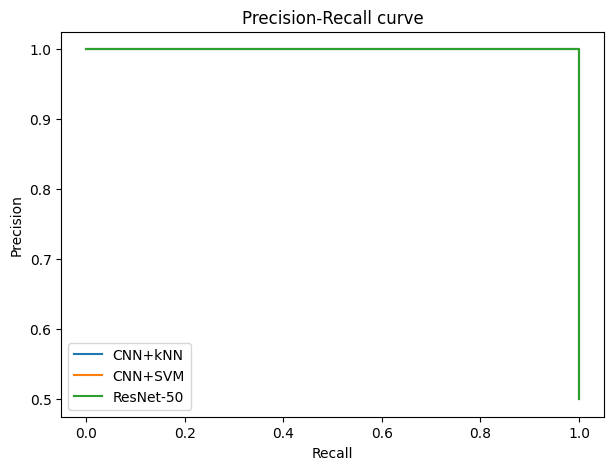

In [16]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def plot_precision_recall_curve(y_true, y_scores, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.plot(recall, precision, label=model_name)

plt.figure(figsize=(7, 5))

# 각 모델별 Precision-Recall Curve를 그립니다.
plot_precision_recall_curve(y_true, y_scores_cnn_knn, 'CNN+kNN')
plot_precision_recall_curve(y_true, y_scores_cnn_svm, 'CNN+SVM')
plot_precision_recall_curve(y_true, y_scores_resnet50, 'ResNet-50')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

### 3. k-Value에 따른 정확도(Accuracy) 비교

44/44 [==============================] - 46s 1s/step
ResNet-50 + k-NN classifier accuracy: 99.35%
ResNet-50 + k-NN classifier accuracy: 98.92%
ResNet-50 + k-NN classifier accuracy: 99.42%
ResNet-50 + k-NN classifier accuracy: 99.06%
ResNet-50 + k-NN classifier accuracy: 99.35%
ResNet-50 + k-NN classifier accuracy: 99.13%
ResNet-50 + k-NN classifier accuracy: 99.35%
ResNet-50 + k-NN classifier accuracy: 99.20%
ResNet-50 + k-NN classifier accuracy: 99.20%
ResNet-50 + k-NN classifier accuracy: 98.84%
ResNet-50 + k-NN classifier accuracy: 98.99%
ResNet-50 + k-NN classifier accuracy: 98.77%
ResNet-50 + k-NN classifier accuracy: 98.55%
ResNet-50 + k-NN classifier accuracy: 98.70%
ResNet-50 + k-NN classifier accuracy: 98.63%


ValueError: x and y must have same first dimension, but have shapes (15,) and (0,)

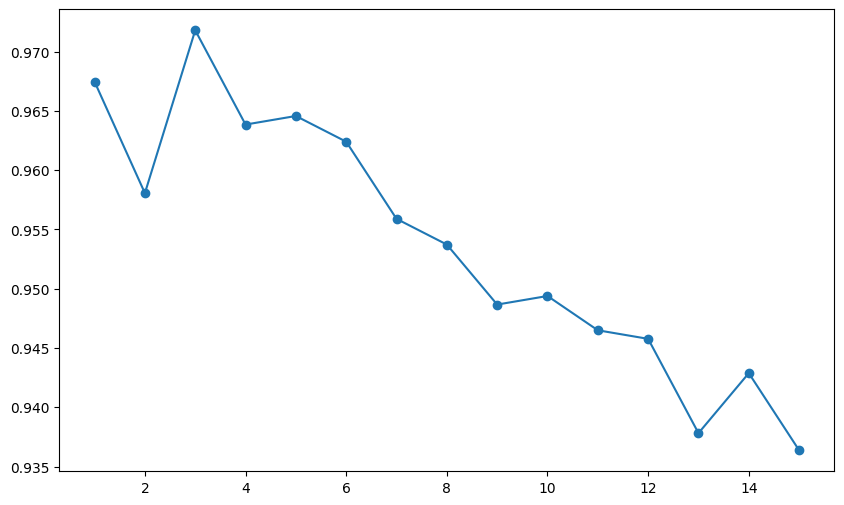

In [19]:
import numpy as np
from sklearn.metrics import accuracy_score

# k 값의 범위 설정 (1부터 15까지)
k_values = range(1, 16)

# k 값에 따른 정확도를 저장할 딕셔너리
accuracy_knn_cnn = []
accuracy_knn_resnet = []
accuracy_svm_resnet = []

for k in k_values:
    # CNN 특징을 사용한 k-NN 분류기
    knn_classifier_cnn = KNeighborsClassifier(n_neighbors=k)
    knn_classifier_cnn.fit(X_train_features, y_train)
    y_pred_cnn = knn_classifier_cnn.predict(X_test_features)
    accuracy_cnn = accuracy_score(y_test, y_pred_cnn)
    accuracy_knn_cnn.append(accuracy_cnn)

    # SVM 분류기 생성 및 훈련
    svm_classifier = SVC(kernel='linear', C=k)
    svm_classifier.fit(X_train_features, y_train)
    # SVM을 사용한 분류
    y_pred_svm = svm_classifier.predict(X_test_features)
    accuracy_resnet = accuracy_score(y_test, y_pred_resnet)
    accuracy_svm_resnet.append(accuracy_resnet)

# 데이터 전처리: ResNet-50에 맞게 입력 데이터 전처리
X_train_resnet = preprocess_input(X_train_scaled)
X_test_resnet = preprocess_input(X_test_scaled)

# ResNet-50을 통한 특징 추출
X_train_resnet_features = resnet50_model.predict(X_train_resnet)
X_test_resnet_features = resnet50_model.predict(X_test_resnet)

# 특징 벡터 평탄화 (훈련을 위해)
X_train_resnet_features_flat = X_train_resnet_features.reshape(X_train_resnet_features.shape[0], -1)
X_test_resnet_features_flat = X_test_resnet_features.reshape(X_test_resnet_features.shape[0], -1)

for k in k_values:
    # k-NN 분류기 (ResNet-50 특징을 사용) 생성 및 훈련
    knn_classifier_resnet = KNeighborsClassifier(n_neighbors=k)
    knn_classifier_resnet.fit(X_train_resnet_features_flat, y_train)

    # k-NN을 사용한 분류 (ResNet-50 특징을 사용)
    y_pred_resnet = knn_classifier_resnet.predict(X_test_resnet_features_flat)

    # 분류 결과의 정확도 평가
    accuracy_resnet = accuracy_score(y_test, y_pred_resnet)
    print(f'ResNet-50 + k-NN classifier accuracy: {accuracy_resnet * 100:.2f}%')

# k 값에 따른 정확도 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_knn_cnn, label='CNN + k-NN', marker='o')
plt.plot(k_values, accuracy_knn_resnet, label='ResNet-50 + k-NN', marker='s')
plt.xlabel('k value')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k value for k-NN classifiers')
plt.legend()
plt.grid(True)
plt.show()

### 4. Runtime Comparison

In [ ]:
import time

# 모델 예측 함수를 가정합니다. 실제 구현 시에는 모델의 predict 메소드를 호출합니다.
def predict_with_model(model, data):
    start_time = time.time()
    model.predict(data)  # 가정된 예측 함수
    return (time.time() - start_time) * 1000  # ms 단위로 반환

# 예제 데이터
data_example = np.random.rand(100, 224, 224, 3)  # 100개의 224x224 RGB 이미지

# 모델별 실행 시간 측정
# 예시로, 여러분의 모델 예측 함수로 대체해야 합니다.
runtime_cnn_knn = predict_with_model(cnn_knn_model, data_example)
runtime_cnn_svm = predict_with_model(cnn_svm_model, data_example)
runtime_resnet50 = predict_with_model(resnet50_model, data_example)

print(f"Runtime for CNN+kNN: {runtime_cnn_knn:.2f} ms")
print(f"Runtime for CNN+SVM: {runtime_cnn_svm:.2f} ms")
print(f"Runtime for ResNet-50: {runtime_resnet50:.2f} ms")


# 테스트(firebase에서 받아오기)

1/1 [==============================] - 0s 453ms/step
['K-004378']


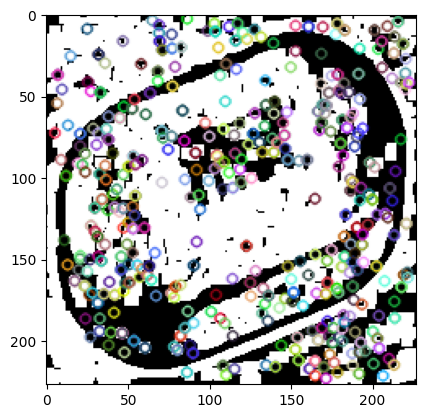

In [37]:
# 주어진 이미지 (processed_image)에 대해 특징 추출 후 k-NN을 사용하여 클래스를 예측합니다.
# CNN 모델로부터 특징 추출기를 만듭니다.
# feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-3].output)

# 이미지를 모델의 입력에 맞는 크기로 조정합니다. (예: 227x227)
input_image = cv2.resize(processed_test_image_rgb, (227, 227))
input_image = np.expand_dims(input_image, axis=0)  # 모델은 배치 차원을 기대합니다.

# CNN을 통해 특징을 추출합니다.
features = feature_extractor.predict(input_image)

# k-NN 분류기를 사용하여 클래스를 예측합니다.
predicted_class = knn_classifier.predict(features)
print(predicted_class)


# 잘라낸 알약 이미지를 시각화합니다.
plt.imshow(cv2.cvtColor(processed_test_image_rgb, cv2.COLOR_BGR2RGB))
plt.show()


# 테스트(firebase storage에서 데이터 불러오기)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 평가

In [ ]:
# 테스트 데이터셋에 대한 예측을 수행합니다.
y_pred = knn.predict(X_test_features)

# 분류 결과를 평가합니다.
print(classification_report(y_test, y_pred))